In [13]:
import os
import sys
sys.path.append('/home/iburenko/SimCLR/')
sys.path.append('/home/iburenko/timm/')
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
from loader import PETDataset, TransformsSimCLR
from timm import create_model, list_models
from simclr import SimCLR
from simclr.modules import NT_Xent, LARS
from transformers import BertTokenizerFast
from tqdm import tqdm
import umap
from torch.utils.data import DataLoader, Dataset
from itertools import combinations_with_replacement
import cv2
import torchvision

%matplotlib inline

In [3]:
def closeness_for_case(m, sorted_m, k):
    ind = (lambda x: [x_low<=x<x_up for x_low, x_up in lowups])(m)
    low, up = lowups[ind.index(True)]
    t = argsort[m][:k]
    ratio = ((low<=t)&(t<up)).sum()/k
    return ratio

def body_closeness_for_case(m, sorted_m, k):
    err = 0
    t = argsort[m][:k]
    for i, elem in enumerate(t):
        true_ind = (lambda x: [x_low<=x<x_up for x_low, x_up in lowups])(m)
        true_low, true_up = lowups[true_ind.index(True)]
        pred_ind = (lambda x: [x_low<=x<x_up for x_low, x_up in lowups])(elem)
        pred_low, pred_up = lowups[pred_ind.index(True)]
        x = (m-true_low)/(true_up-true_low)
        y = (elem-pred_low)/(pred_up-pred_low)
        err += abs(x-y)
    return err/k

def angular_closeness_for_case(m, sorted_m, argsort, k):
    ind = (lambda x: [x_low<=x<x_up for x_low, x_up in lowups])(m)
    low, up = lowups[ind.index(True)]
    t = argsort[m][:k]
    slices_from_case = ((low<=t)&(t<up)).sum()
    angular_closeness = 0
    angular_farness = 0
    for i in range(k):
        ind = argsort[m][i]
        dot_prod = sorted_m[m][i]
        if low<=ind<up:
            angular_closeness += dot_prod
        else:
            angular_farness += dot_prod
    return angular_closeness/(slices_from_case+1e-4), angular_farness/(k-slices_from_case+1e-4)
        

def mean_closeness_for_case(ind, argsort, k):
    low, up = lowups[ind]
    return sum([closeness_for_case(i, argsort, k) for i in range(low, up)])/(up-low)

def mean_body_closeness_for_case(ind, argsort, k):
    low, up = lowups[ind]
    return sum([body_closeness_for_case(i, argsort, k) for i in range(low, up)])/(up-low)

def mean_angular_closeness_for_case(ind, sorted_m, argsort, k):
    low, up = lowups[ind]
    angular_metric = [
        angular_closeness_for_case(i, sorted_m, argsort, k) for i in range(low, up)
    ]
    angular_sim = sum([elem[0] for elem in angular_metric])
    angular_dissim = sum([elem[1] for elem in angular_metric])
    return angular_sim/(up-low), angular_dissim/(up-low)

In [2]:
dataset = PETDataset('val', 256)

In [6]:
torch.cuda.set_device('cuda:2')
# state1 = torch.load('/data/burenko/logs/cl/weights/medclr_100.w', map_location='cpu')
# state2 = torch.load('/data/burenko/logs/cl/weights/2body1/medclr_100.w', map_location='cpu')
for model_name in sorted(os.listdir('/data/burenko/logs/cl/logs/runs/run_0_2021_07_22_15_39/checkpoints/')):
    print(model_name)
    state_path = '/data/burenko/logs/cl/logs/runs/run_0_2021_07_22_15_39/checkpoints/'+model_name
    state = torch.load(state_path)
    # state1 = torch.load('/data/burenko/logs/cl/logs/runs/run_0_2021_07_22_15_39/checkpoints/medclr_600.w', map_location='cpu')
    # state2 = torch.load('/data/burenko/logs/cl/logs/runs/run_4_2021_07_16_11_18/checkpoints/medclr_10.w', map_location='cpu')

    ct_encoder = create_model('wide_resnet50_2', in_chans=1, pretrained=True)
    # pet_encoder = create_model('wide_resnet50_2', in_chans=1, pretrained=True)
    n_features = ct_encoder.fc.in_features
    projection_dim = 1024
    model1 = SimCLR(projection_dim, n_features, ct_encoder)
    # model2 = SimCLR(projection_dim, n_features, ct_encoder, pet_encoder)
    _ = model1.load_state_dict(state['model_state'])
    _ = model1.cuda().eval()
    # _ = model2.load_state_dict(state2['model_state'])
    # _ = model2.cuda().eval()

    upper_limit = 3062
    all_h_i = torch.zeros(upper_limit, 2048)
    all_h_j = torch.zeros(upper_limit, 2048)
    all_z_i = torch.zeros(upper_limit, 1024)
    all_z_j = torch.zeros(upper_limit, 1024)

    # all_h_i2 = torch.zeros(upper_limit, 2048)
    # all_h_j2 = torch.zeros(upper_limit, 2048)
    # all_z_i2 = torch.zeros(upper_limit, 1024)
    # all_z_j2 = torch.zeros(upper_limit, 1024)

    with torch.no_grad():
        for i in tqdm(range(upper_limit)):
            ct, pet = dataset[i]
            ct = ct.unsqueeze(0).unsqueeze(0)
            pet = pet.unsqueeze(0).unsqueeze(0)
            h_i, h_j, z_i, z_j = model1(ct.cuda(), pet.cuda())
            h_i, h_j, z_i, z_j = h_i.cpu()[0], h_j.cpu()[0], z_i.cpu()[0], z_j.cpu()[0]
            all_h_i[i] = h_i
            all_h_j[i] = h_j
            all_z_i[i] = z_i
            all_z_j[i] = z_j

    #         h_i, h_j, z_i, z_j = model2(ct.cuda(), pet.cuda())
    #         h_i, h_j, z_i, z_j = h_i.cpu()[0], h_j.cpu()[0], z_i.cpu()[0], z_j.cpu()[0]
    #         all_h_i2[i] = h_i
    #         all_h_j2[i] = h_j
    #         all_z_i2[i] = z_i
    #         all_z_j2[i] = z_j
    #         break

#     plt.figure(figsize=(14,14))
#     plt.subplot(121)
#     plt.imshow((all_z_i@all_z_i.T)/(all_z_i.norm(dim=1).unsqueeze(0).T@all_z_i.norm(dim=1).unsqueeze(0)), vmin=-1, vmax=1)
    
#     plt.figure(figsize=(14,14))
#     plt.subplot(121)
#     plt.imshow((all_z_j@all_z_j.T)/(all_z_j.norm(dim=1).unsqueeze(0).T@all_z_j.norm(dim=1).unsqueeze(0)), vmin=-1, vmax=1)

#     plt.figure(figsize=(14,14))
#     plt.subplot(121)
#     plt.imshow((all_h_i@all_h_i.T)/(all_h_i.norm(dim=1).unsqueeze(0).T@all_h_i.norm(dim=1).unsqueeze(0)),vmin=-1, vmax=1)

#     plt.figure(figsize=(14,14))
#     plt.subplot(121)
#     plt.imshow((all_h_j@all_h_j.T)/(all_h_j.norm(dim=1).unsqueeze(0).T@all_h_j.norm(dim=1).unsqueeze(0)), vmin=-1, vmax=1)

    for i, (a,b) in enumerate(combinations_with_replacement([all_h_i, all_h_j], 2)):
        print('i = ',i)
        m = (a@b.T)/(a.norm(dim=1).unsqueeze(0).T@b.norm(dim=1).unsqueeze(0))
        print('m: ')
        plt.figure(figsize=(6,6))
        plt.imshow(m, vmin=-1, vmax=1)
        plt.show()

        lowups = ([0,299],[299,562],[562,861],[861,1196],[1196,1495],[1495,1794],[1794,2093],[2093,2356],[2356,2907], [2907, 3206])
        fig, ax = plt.subplots(2,5, figsize=(9,6))
        for j, (low, up) in enumerate(lowups):
            ax[j//5, j%5].imshow(m[low:up ,low:up], vmin=-1, vmax=1)
            ax[j//5, j%5].axis('off')
        plt.show()
        sorted_m, argsort = torch.sort(m, descending=True)
        n = 100
        angular_sim = np.zeros(n)
        angular_dissim = np.zeros(n)
        body_sim = np.zeros(n)
        closeness = np.zeros(n)
        for k in range(n):
            angular = mean_angular_closeness_for_case(0, sorted_m, argsort, k+1)
            angular_sim[k] = angular[0]
            angular_dissim[k] = angular[1]
            body_sim[k] = mean_body_closeness_for_case(0, argsort, k+1)
            closeness[k] = mean_closeness_for_case(0, argsort, k+1)
        print('ang sim')
        fig, ax = plt.subplots(1,2)
        ax[0].scatter(np.arange(n), angular_sim)
        ax[1].scatter(np.arange(n), angular_dissim)
        plt.show()
        print('body sim')
        plt.scatter(np.arange(n), body_sim)
        plt.show()
        print('closeness sim')
        plt.scatter(np.arange(n), closeness)
        plt.show()

medclr_100.w


  0%|          | 0/3062 [00:00<?, ?it/s]/home/fzhukov/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
 36%|███▌      | 1099/3062 [00:25<00:45, 43.07it/s]


KeyboardInterrupt: 

In [5]:
dataset = PETDataset('train', 256)

In [8]:

dataloader = DataLoader(dataset, batch_size=256, num_workers=0)

In [9]:
mean_ct = 0
std_ct = 0
mean_pet = 0
std_pet = 0
for elem in tqdm(dataloader, total=len(dataloader)):
    mean_ct += elem[0].mean()
    std_ct += elem[0].std()
    mean_pet += elem[1].mean()
    std_pet += elem[1].std()

  1%|          | 2/217 [00:09<16:25,  4.58s/it]


KeyboardInterrupt: 

In [ ]:
with open('train_val_split.json', 'r') as file:
    data = json.load(file)

In [ ]:
new_dict = dict()
for key, val in data.items():
    temp_dict = dict()
    temp_keys = sorted(val.keys())
    for new_key in temp_keys:
        temp_dict[new_key] = sorted(os.listdir(new_key))
    new_dict[key] = temp_dict

In [ ]:
with open('train_val_split.json', 'w') as file:
    json.dump(new_dict, file)

In [9]:
class PETDataset(Dataset):
    def __init__(self, train, size=64):
        assert train in ['train', 'val']
        self.train = train
        resize = torchvision.transforms.Resize(size=size)
        with open('train_val_split.json', 'r') as file:
            self.image_filenames = json.load(file)[train]
        self.all_lens = [len(val) for val in self.image_filenames.values()]
        self.cumsum = np.array([sum(self.all_lens[:i]) for i in range(len(self.all_lens)+1)])
    
    def __len__(self):
        return self.cumsum[-1]

    def __getitem__(self, idx):
        case_id = (idx >= self.cumsum).sum() - 1
        key = list(self.image_filenames.keys())[case_id]
        slice_id = idx - self.cumsum[case_id]
        im = cv2.imread(key+'/'+self.image_filenames[key][slice_id])
        im = np.moveaxis(im, -1, 0)
        return self._normalize(im[1], 'ct'), self._normalize(im[2], 'pet')
    
    def _normalize(self, image, mode):
        assert mode in ['ct', 'pet']
        mean = 69.1 if mode == 'ct' else 4.7
        std = 55.6 if mode == 'ct' else 18.1
        return (image-mean)/std

In [14]:
dataset = PETDataset('train', 64)

In [15]:
im = dataset[100]

In [16]:
type(im[0])

torch.Tensor

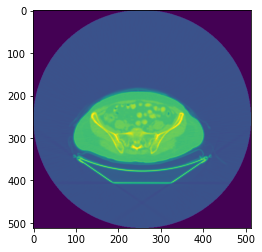

In [18]:
plt.imshow(im[0])

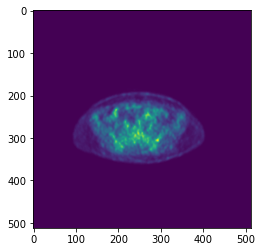

In [19]:
plt.imshow(im[1])